## Validation of sphere fitting (Figure 2)

In [1]:
# Import modules
import sys, h5py
import numpy as np
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Simulation parameters
nsamples = 20
nsizes   = 300
nintensities = 80
shape = (nsamples, nsizes*nintensities)
pulse_length = 50e-15 #[s]
pixelsize = 110e-3 #[mm]
detector_distance = 2400 #[mm]
wavelength = 0.22621e-9 #[m]
diameter_limits = slice(35,300, None)
islice  = slice(20,80, None)

In [3]:
# IO settings
filename = '../meta/sphere_simulation.h5'
plotdir  = '/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/'

### 1. Loading data from file

In [4]:
with h5py.File(filename, 'r') as f:
    diameter_true   = f["simulation"]["diameter"][:].reshape(shape)
    intensity_true  = f["simulation"]["intensity"][:].reshape(shape)
    centerx_true    = f["simulation"]["cx"][:].reshape(shape)
    centery_true    = f["simulation"]["cy"][:].reshape(shape)
    diameter_fit    = f["results"]["diameter"][:].reshape(shape)
    intensity_fit   = f["results"]["intensity"][:].reshape(shape)
    centerx_fit     = f["results"]["cx"][:].reshape(shape)
    centery_fit     = f["results"]["cy"][:].reshape(shape)
    chisquared      = f["results"]["chisquared"][:].reshape(shape)
    hitscore_npeaks = f["results"]["npeaks"][:].reshape(shape)

### 2. Converting to different units

In [5]:
# True Intensity in units of mJ/mu2
intensity_true_mJum2 = intensity_true * (1000 * pulse_length) / 1e8

# Fitted intensity in units of mJ/um2
intensity_fit_mJum2  = intensity_fit

# Intensity in Nr. of photons
h = 6.62606957e-34 #Js
c = 299792458 #m/s
hc = h*c  #Jm
intensity_true_NrPhum2 = ((intensity_true_mJum2 / 1000.) * wavelength) / (hc)
intensity_fit_NrPhum2  = ((intensity_fit_mJum2 / 1000.) * wavelength) / (hc)

# Make a grid of size vs. intensity
grid_shape = (nintensities, nsizes)
x = diameter_true[0].reshape(grid_shape)[0,:]
y = intensity_true_NrPhum2[0].reshape(grid_shape)[:,0]
X,Y = np.meshgrid(x, y)

# Intensity limits
ilimits = [y[islice.start], y[islice.stop-1]]
idetection = ilimits[0]

# Translate pixel to mrad
centerx_true_mrad = np.arctan(centerx_true * pixelsize / detector_distance) * 1000. + 0.7
centery_true_mrad = np.arctan(centery_true * pixelsize / detector_distance) * 1000. + 0.6
centerx_fit_mrad  = np.arctan(centerx_fit  * pixelsize / detector_distance) * 1000. + 0.7
centery_fit_mrad  = np.arctan(centery_fit  * pixelsize / detector_distance) * 1000. + 0.6

### 3. Computing errors (simulation vs. truth)

In [6]:
# Absolute error in center position
absolute_error_centerx_mrad = (centerx_fit_mrad - centerx_true_mrad).mean(axis=0)
absolute_error_centery_mrad = (centery_fit_mrad - centery_true_mrad).mean(axis=0)
absolute_error_centerx = (centerx_fit - centerx_true).mean(axis=0)
absolute_error_centery = (centery_fit - centery_true).mean(axis=0)
#absolute_error_centerr = np.sqrt(absolute_error_centerx**2 + absolute_error_centery**2)

# Absolute error in diameter
absolute_error_diameter  = (diameter_fit - diameter_true).mean(axis=0)

# Absolute error in intensity
absolute_error_intensity_NrPhum2 = (intensity_fit_NrPhum2 - intensity_true_NrPhum2).mean(axis=0)

hitscore_mean = hitscore_npeaks.mean(axis=0)
hits   = (hitscore_mean >= 600) & (diameter_true[0] > diameter_limits.start) & (intensity_true_NrPhum2[0] > idetection)
blanks = hitscore_mean <  600
middle = (hitscore_mean >= 600) & ~((diameter_true[0] > diameter_limits.start) & (intensity_true_NrPhum2[0] > idetection))

diameter_limit  = diameter_true.mean(axis=0).reshape(grid_shape) > diameter_limits.start
intensity_limit = intensity_true_NrPhum2.mean(axis=0).reshape(grid_shape) >= idetection

good_x = X[(hitscore_mean.reshape(grid_shape) > 600) & diameter_limit & intensity_limit]
good_y = Y[(hitscore_mean.reshape(grid_shape) > 600) & diameter_limit & intensity_limit]

middle_x = X[(hitscore_mean.reshape(grid_shape) > 600) & ~(diameter_limit & intensity_limit)]
middle_y = Y[(hitscore_mean.reshape(grid_shape) > 600) & ~(diameter_limit & intensity_limit)]

bad_x = X[(hitscore_mean.reshape(grid_shape) < 600)]
bad_y = Y[(hitscore_mean.reshape(grid_shape) < 600)]

intensity_true_hits   = intensity_true_NrPhum2.mean(axis=0)[hits]
intensity_true_blanks = intensity_true_NrPhum2.mean(axis=0)[blanks]
intensity_true_middle = intensity_true_NrPhum2.mean(axis=0)[middle]

### 4. Plotting

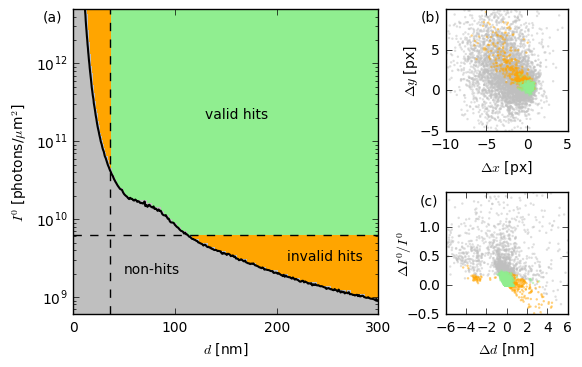

In [7]:
plot = plotting.Plot(fontsize=10, cols=3, rows=2, exclude=[0,1,3,4], border_in=0.5, aspect=1, window_width=1000, 
                     colorbar=False, legend=False, save_png=True)
plot.add_axes((0,0), 2,2, hfrac=1, padx=-0.01)
plot.title_label = 3*['']
plot.xlabel = [r'$\Delta x$ [px]',
               r'$\Delta d$ [nm]',
               r'$d$ [nm]']
plot.ylabel = [r'$\Delta y$ [px]',
               r'$\Delta I^0 / I^0$',
               r'$I^0$ [photons/$\mu$m$^2$]']

plot.plotting_correlation(2, [good_x, middle_x, bad_x], [good_y, middle_y, bad_y],
                          logy=True, xlim=(0,nsizes), ylim=(6e8, 5e12), markersize=10, marker='s', alpha=1,
                          labels=[r'good', 'bad', 'not detected'],
                          color=[ 'lightgreen', 'orange', '0.75'])
plot.plotting_a_contour(2, X,Y,hitscore_mean.reshape(grid_shape),
                        (600,), colors='k', linewidths=1.5, label=False, format='%d')
plot.axes[2].axvline(diameter_limits.start + 1.5, color='k', linestyle='--')
plot.axes[2].axhline(idetection + 4e8, color='k', linestyle='--')
plot.axes[2].text(-30, 5e12, '(a)', va='top', ha='left', fontsize=10)
plot.axes[2].set_xticks([0,100,200,300])
plot.axes[2].text(50, 2e9, 'non-hits', fontsize=10)
plot.axes[2].text(210, 3e9, 'invalid hits', fontsize=10)
plot.axes[2].text(130, 2e11, 'valid hits', fontsize=10)

plot.plotting_correlation(0,
                          [absolute_error_centerx[blanks],
                           absolute_error_centerx[middle],
                           absolute_error_centerx[hits]],
                          [absolute_error_centery[blanks],
                           absolute_error_centery[middle],
                           absolute_error_centery[hits]],
                          xlim=[-10,5], ylim=[-5,10], logx=False, logy=False,
                          color=['0.75', 'orange', 'lightgreen'],
                          markersize=3, marker='o', alpha=0.5)
plot.axes[0].tick_params(axis='y', right='on', left='on', labelright='off', labelleft='on', labelcolor='k', direction='in')
plot.axes[0].text(-13, 10, '(b)', va='top', ha='left', fontsize=10)
plot.axes[0].yaxis.labelpad = 0
plot.axes[0].set_xticks([-10,-5,0,5])
plot.axes[0].set_yticks([-5,0,5])

plot.plotting_correlation(1,
                          [absolute_error_diameter[blanks],
                           absolute_error_diameter[middle],
                           absolute_error_diameter[hits]],
                          [absolute_error_intensity_NrPhum2[blanks] / intensity_true_blanks,
                           absolute_error_intensity_NrPhum2[middle] / intensity_true_middle,
                           absolute_error_intensity_NrPhum2[hits] / intensity_true_hits],
                          logx=False, logy=False, xlim=[-6,6], ylim=[-.5, 1.6],
                          color=['0.75', 'orange', 'lightgreen'],
                          markersize=3, marker='o', alpha=0.5)
plot.axes[1].text(-8.5, 1.58, '(c)', va='top', ha='left', fontsize=10)
plot.axes[1].yaxis.labelpad = -5
plot.axes[1].set_yticks([-0.5, 0, 0.5, 1.0])

#plot.save(plotdir + 'fig_simulation_simple.png') 
plot.show()

**Figure 2.**
Validation of the classification procedure based on simulation of spheres with different particle sizes and photon intensities.                                           
(a) Classification of patterns as non-hits (gray area) and hits (above the black solid line) as function of particle size and intensity.                                           
Data points with strong deviation in the size and intensity estimates are depicted in orange, the rest is shown in green and separated by black dashed lines.                      
(b) Distribution errors in diffraction center.                                                                                                                                     
(c) Distribution of errors in particle size and intensity (normalized to the simulated intensity).                                                                                 
A statistical summary of the green distributions is given below.

In [8]:
print "x, std = ", np.std(absolute_error_centerx[hits])                                                                                                                           
print "y, std = ", np.std(absolute_error_centery[hits])                                                                                                                           
print "d, std = ", np.std(absolute_error_diameter[hits])                                                                                                                          
print "I, std = ", np.std(absolute_error_intensity_NrPhum2[hits] / intensity_true_hits)#intensity_fit_NrPhum2.mean(axis=0)[hits])
                                                                                                                                                                                  
print "x, min = ", np.min(absolute_error_centerx[hits])                                                                                                                           
print "y, min = ", np.min(absolute_error_centery[hits])                                                                                                                           
print "d, min = ", np.min(absolute_error_diameter[hits])                                                                                                                          
print "I, min = ", np.min(absolute_error_intensity_NrPhum2[hits] / intensity_true_hits)                                                                                     
                                                                                                                                                                                  
print "x, max = ", np.max(absolute_error_centerx[hits])                                                                                                                           
print "y, max = ", np.max(absolute_error_centery[hits])                                                                                                                           
print "d, max = ", np.max(absolute_error_diameter[hits])                                                                                                                          
print "I, max = ", np.max(absolute_error_intensity_NrPhum2[hits] / intensity_true_hits)  

x, std =  0.0948476984557
y, std =  0.0810889166573
d, std =  0.147354404899
I, std =  0.0290164207392
x, min =  -1.45763483549
y, min =  -0.586941577885
d, min =  -0.913126414295
I, min =  -0.0116813918086
x, max =  1.05037254708
y, max =  1.98510603377
d, max =  3.18761118119
I, max =  0.249169344494
